In [2]:
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [3]:
from mujoco_playground import wrapper
from mujoco_playground import registry

In [4]:
registry.manipulation.ALL_ENVS

('AlohaHandOver',
 'AlohaSinglePegInsertion',
 'PandaPickCube',
 'PandaPickCubeOrientation',
 'PandaPickCubeCartesian',
 'PandaOpenCabinet',
 'PandaRobotiqPushCube',
 'LeapCubeReorient',
 'LeapCubeRotateZAxis')

In [5]:
env_name = 'PandaPickCubeOrientation'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)

In [6]:
env_cfg

action_repeat: 1
action_scale: 0.04
ctrl_dt: 0.02
episode_length: 150
reward_config:
  scales:
    box_target: 8.0
    gripper_box: 4.0
    no_floor_collision: 0.25
    robot_target_qpos: 0.3
sim_dt: 0.005

In [7]:
from mujoco_playground.config import manipulation_params
ppo_params = manipulation_params.brax_ppo_config(env_name)
ppo_params

action_repeat: 1
batch_size: 512
discounting: 0.97
entropy_cost: 0.02
episode_length: 150
learning_rate: 0.001
network_factory:
  policy_hidden_layer_sizes: !!python/tuple
  - 32
  - 32
  - 32
  - 32
  policy_obs_key: state
  value_hidden_layer_sizes: !!python/tuple
  - 256
  - 256
  - 256
  - 256
  - 256
  value_obs_key: state
normalize_observations: true
num_envs: 2048
num_evals: 4
num_minibatches: 32
num_timesteps: 20000000
num_updates_per_batch: 8
reward_scaling: 1.0
unroll_length: 10

In [11]:
env.observation_size

66

In [7]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    progress_fn=progress,
    seed=1
)

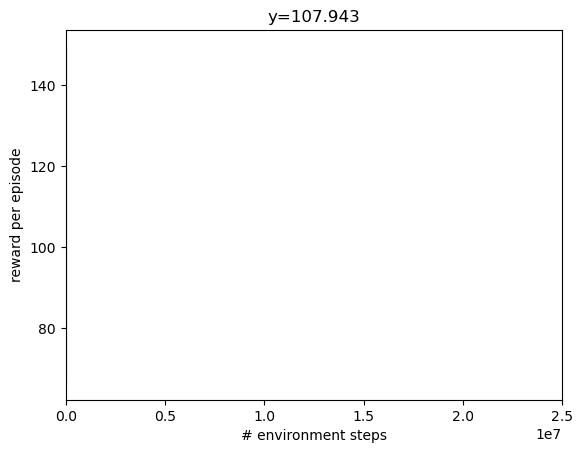

In [ ]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  state = jit_reset(rng)
  rollout.append(state)
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

render_every = 1
frames = env.render(rollout[::render_every])
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)